# Forecasting of a group of 7 wind farms - the GEFCOM dataset

## Presentation of the dataset

## Generalities

- Initially used for the Kaggle GEFCOM 2012 wind power forecasting competition.
- More than one year of data available: from July the 4th 2009 to December the 31st 2010.
- Normalized power production of 7 farms which are in a similar geographic area.
- Issued with Numerical Weather Predictions (NWPs).

## Inputs 

Wind related NWPs:

- Horizontal wind speed $u$.
- Vertical wind speed $v$.
- Wind speed norm $ws = \sqrt{u^2+v^2}$.
- Wind direction $wd$.

All those NWPs are given for each wind farm and between 1 and 48 hours ahead.

In [1]:
from IPython.display import HTML,display,Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this document is by default hidden.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import tensorflow as tf
import numpy as np
import time
import numpy as np
import scipy as sp
import keras
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import RMSprop
from keras.datasets import mnist
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn as sk
import string
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Figure, Layout
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pywt
import datetime as dt
import os,sys
import functools

from keras.constraints import maxnorm

from sklearn import linear_model

from utility_functions import *
from functions_NN import *

### rpy2 ###

import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
Rssa = importr("Rssa")
mgcv = importr("mgcv")

from sklearn import linear_model
from IPython.display import Image
from tabulate import tabulate

from rpy2.robjects import IntVector, Formula

plotly.offline.init_notebook_mode(connected=True)

def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

Using TensorFlow backend.


In [17]:

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import r, pandas2ri
import rpy2.robjects.numpy2ri as rpyn
pandas2ri.activate()

Y_hat_leust = np.asarray(r.readRDS("data/y_hat_leust.RDS"))

In [3]:
wf_df = pd.read_csv("wf_df_all_improved_ssa.csv")
wf_df = wf_df.drop("Unnamed: 0",axis=1)
learning,validation,evaluation = generate_sets(wf_df,0.6,0.8)  

train = pd.read_csv("data/train.csv",sep=",")

date_min = pd.to_datetime("2009070213",format="%Y%m%d%H")
date_max = pd.to_datetime("2010123123",format="%Y%m%d%H")

## Preparation of the data ##
train["date"] = pd.to_datetime(train["date"],format="%Y%m%d%H")
train = train[np.asarray([train.date >= date_min,train.date <= date_max]).all(axis=0)]

del wf_df

simu_1_all7 = pd.read_csv("results_simu/simu_1_all7.csv")

simu_1_all7 = simu_1_all7.drop('Unnamed: 0',axis=1)


Correlation matrix between power production and wind speed forecasts for farm 4


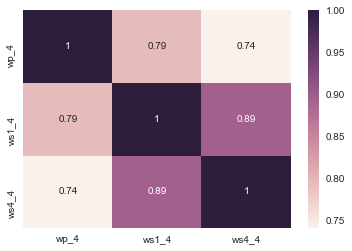

In [12]:
Corr_mat = learning[["wp_4","ws1_4","ws4_4"]].corr()

print("Correlation matrix between power production and wind speed forecasts for farm 4")
sns.heatmap(Corr_mat,annot=True)

In [4]:
plotly_plot(["Production of farm 1","1 to 12 hours ahead wind speed forecast",
        "37 to 48 hours ahead wind speed forecast"],learning.date,True,learning.wp_1,learning.ws1_1,learning.ws4_1)

The inputs $x$ are all normalized according to the formula

$\tilde{x} \leftarrow \dfrac{x-\hat{\mu}}{\hat{\sigma}}$

where $\hat{\mu}$ and $\hat{\sigma}$ are estimated on the learning set.

- Since we aim at forecasting more than one day ahead, only the NWPs provided between 37 and 48 hours ahead will be used.
- Data is always splitted as following : 60% for learning of the neural networks (July the 4th 2009 to April the 27th 2010), validation on 20% (from the latter date to September the 13th) and the remaining 20% for evaluation (September the 13th to the 31st of December 2010)

## Methodology of the forecasting process

## Taking advatange of the correlation existing between the wind farms and the provided NWPs

Correlation matrix of the 7 wind farms


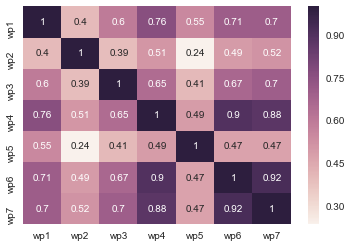

In [5]:
%matplotlib inline

Corr_mat =train.drop("date",axis=1).corr()

print("Correlation matrix of the 7 wind farms")
sns.heatmap(Corr_mat,annot=True)

Training of a single neural network will be performed jointly to take advantage of this correlation, as well as the one existing between the wind speed forecasts.

## Singular Spectrum Analysis to clean the inputs and improve the learning process

Decomposition of a time-series into a sum of components (hereafter called harmonics).

### SSA process

- 1st step - construction of the trajectory matrix $Y$: Let $y = \{y_1,y_2, \dots, y_T \}$ be a time-series. It is mapped into a hankel matrix $\underline{\underline{Y}} = [\underline{Y}_1,\underline{Y}_2, \dots , \underline{Y}_{T-L+1}]$ where $\underline{Y}_i = [y_i, y_{i+1}, \dots, y_{i+L-1}]$ and $L$ is the only parameter of SSA called the window length.



- 2nd step - Singular Value Decomposition: the eigenvalues $\lambda_i$ of $\underline{\underline{Y}} \underline{\underline{Y}}^T$ and the corresponding orthonormal basis $U_i$  are calculated to yield the singular value decomposition of $\underline{\underline{Y}}$ :

$$ \underline{\underline{Y}} = \underline{\underline{Y}}_1 + \underline{\underline{Y}}_2 + \dots + \underline{\underline{Y}}_d$$ where $\underline{\underline{Y}}_i$ is defined through the orthogonal eigenbasis and $\underline{\underline{Y}}$. 



- 3rd step - Grouping: the matrices $\underline{\underline{Y}}_i$ are split and summed into groups.

- 4th step - Diagonal averaging: Transformation back from the matrices $\underline{\underline{Y}}_i$ into time-series by summing the terms diagonically.

## Improvement of data with SSA

SSA is used both to improve the wind speed NWPs and the wind power data on the learning set. The process is the following for every wind farm:

* SSA on wind power data: only the 30 first harmonics are kept (usually last harmonics correspond to noise) to yield an improved wind power time-series $\tilde{wp}$.


* SSA on wind speed forecasts: initialize a new improved time-series $\tilde{ws} \leftarrow H_0$.

for each other harmonic $H$:
 - if adding harmonic $H$ increases correlation with the improved wind power $\tilde{wp}$, add it to the main time-series.
 - else discard it and proceed to the next one.

This process is repeated for all the wind farms from 1 to 7. Expected effect is that this collective improvement of inputs and labels jointly improve the prediction accuracy.

Correlation between the wind power (improved or not) and the wind speed NWP (improved or not) for farm 3


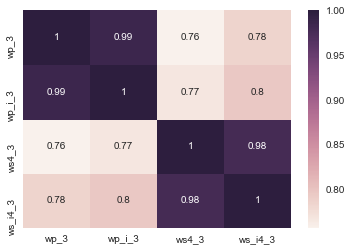

In [6]:
Corr_mat =learning[["wp_3","wp_i_3","ws4_3","ws_i4_3"]].corr()

print("Correlation between the wind power (improved or not) and the wind speed NWP (improved or not) for farm 3")
sns.heatmap(Corr_mat,annot=True)

## Selection of the network architecture

Grid search or random search is performed to select the network structure. The one with the best results on the validation set is kept.

## Numerical results

### Forecasting error measures

Prediction errors are assessed with the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).

$$MAE = \dfrac{1}{T} \sum_{t=1}^T |y_t - \hat{y}_t|$$

and

$$RMSE = \sqrt{\dfrac{1}{T} \sum_{t=1}^T (y_t - \hat{y}_t)^2 }$$



In order to tone down variability due to a certain weight initialization during the learning process, $B=100$ repetitions of the learning - evaluation process are performed, and the standard errors of the MAE and RMSE are calculated.

### Benchmark 

Method implemented by the winning team of the competition (albeit it was used for a specific set of rules with missing data).

<center>
<img src="Figures/flowchart_leustagos.png" alt="Drawing" style="width: 700px;"/>
</center>

In [7]:
simu_leust_csv=pd.read_csv("results_simu/leustagos_sep_error.csv")
simu_leust_csv = simu_leust_csv.drop("Unnamed: 0",axis=1)

simu_leust_csv.Farm = np.tile(np.arange(1,8),18)

simu_leust = np.zeros((7,4))
    
for k in range(1,8):
    simu_leust[k-1,:] = [np.mean(simu_leust_csv.MAE[simu_leust_csv.Farm==k]),np.mean(simu_leust_csv.RMSE[simu_leust_csv.Farm==k]),
            np.std(simu_leust_csv.MAE[simu_leust_csv.Farm==k]),
            np.std(simu_leust_csv.RMSE[simu_leust_csv.Farm==k])]
    
test = pd.DataFrame(simu_leust)
test.columns = ["MAE","RMSE","Std MAE","Std RMSE"]

test_html = test.to_html()

### First try: simple NN trained separately for each farm

A single neural network is trained for every farm. Inputs consist of:

- Horizontal wind speed $u$.
- Wind speed norm $ws$.
- Square and cube of wind speed $ws^2, ws^3$.
- Wind direction $wd$.
- Wind speed and direction unification $ws.angle_t$ as well as its lagged versions $ws.angle_{t-1}$, $ws.angle_{t-2}$, $ws.angle_{t-3}$.

### Comparison of performance between our separate NN and the benchmark


<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "5"><font size="5"><center> Separate NN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <td><font size="4">Farm </size></td>
      <td><font size="4">MAE</size></td>
      <td><font size="4">RMSE</size></td>
      <td><font size="4">STD MAE</size></td>
      <td><font size="4">STD RMSE</size></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><font size="3">1</size></td>
      <td><font size="3">0.145887</size></td>
      <td><font size="3">0.189524</size></td>
      <td><font size="3">0.003189</size></td>
      <td><font size="3">0.005311</size></td>
    </tr>
    <tr>
      <td><font size="3">2</td>
      <td><font size="3">0.154079</size></td>
      <td><font size="3">0.201192</size></td>
      <td><font size="3">0.004905</size></td>
      <td><font size="3">0.008698</size></td>
    </tr>
    <tr>
      <td><font size="3">3</td>
      <td><font size="3">0.165352</size></td>
      <td><font size="3">0.217752</size></td>
      <td><font size="3">0.006899</size></td>
      <td><font size="3">0.009669</size></td>
    </tr>
    <tr>
      <td><font size="3">4</td>
      <td><font size="3">0.164396</size></td>
      <td><font size="3">0.215926</size></td>
      <td><font size="3">0.006208</size></td>
      <td><font size="3">0.008502</size></td>
    </tr>
    <tr>
      <td><font size="3">5</td>
      <td><font size="3">0.165698</size></td>
      <td><font size="3">0.231216</size></td>
      <td><font size="3">0.005829</size></td>
      <td><font size="3">0.009495</size></td>
    </tr>
    <tr>
      <td><font size="3">6</td>
      <td><font size="3">0.156721</size></td>
      <td><font size="3">0.208503</size></td>
      <td><font size="3">0.007193</size></td>
      <td><font size="3">0.010422</size></td>
    </tr>
    <tr>
      <td><font size="3">7</td>
      <td><font size="3">0.145954</size></td>
      <td><font size="3">0.190549</size></td>
      <td><font size="3">0.008240</size></td>
      <td><font size="3">0.010821</size></td>
    </tr>
  </tbody>
</table> </td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "4"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: right;">
      <td><font size="4">MAE</font></td>
      <td><font size="4">RMSE</font></td>
      <td><font size="4">STD MAE</font></td>
      <td><font size="4">STD RMSE</font></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><font size="3">0.117720</size></td>
      <td><font size="3">0.158399</size></td>
      <td><font size="3">5.699520e-07</size></td>
      <td><font size="3">1.113477e-06</size></td>
    </tr>
    <tr>
      <td><font size="3">0.154229</size></td>
      <td><font size="3">0.204031</size></td>
      <td><font size="3">4.143718e-08</size></td>
      <td><font size="3">6.441946e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.125536</size></td>
      <td><font size="3">0.175593</size></td>
      <td><font size="3">1.968868e-07</size></td>
      <td><font size="3">2.945015e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.127818</size></td>
      <td><font size="3">0.173202</size></td>
      <td><font size="3">1.513683e-07</size></td>
      <td><font size="3">1.977831e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.134983</size></td>
      <td><font size="3">0.192555</size></td>
      <td><font size="3">2.909187e-08</size></td>
      <td><font size="3">5.730433e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.126375</size></td>
      <td><font size="3">0.167126</size></td>
      <td><font size="3">2.131500e-07</size></td>
      <td><font size="3">3.395990e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.119723</size></td>
      <td><font size="3">0.166467</size></td>
      <td><font size="3">1.048249e-07</size></td>
      <td><font size="3">1.887182e-07</size></td>
    </tr>
  </tbody>
</table> </td>

</table>

### Second try: jointly trained neural network

One single NN for all the 7 wind farms to take advantage of their correlation.

In [8]:
#simu_7_html = simu_7_all7[['MAE', 'RMSE','STD MAE','STD RMSE']].to_html()
#print(simu_7_html)

#df_error_NN_7 = pd.read_csv("results_simu/refined/error_df_NN_c.csv")
#df_error_NN_7 = df_error_NN_7.drop("Unnamed: 0",axis=1)

#df_error_NN_7_html = df_error_NN_7[['MAE', 'RMSE','STD MAE','STD RMSE']].to_html()

#print(df_error_NN_7_html)

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "5"><font size="5"><center> Joint NN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <td><font size="4">Farm </size></td>
      <td><font size="4">MAE</size></td>
      <td><font size="4">RMSE</size></td>
      <td><font size="4">STD MAE</size></td>
      <td><font size="4">STD RMSE</size></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th><font size="3">1</size></th>
      <td><font size="3">0.129186</size></td>
      <td><font size="3">0.166809</size></td>
      <td><font size="3">0.001156</size></td>
      <td><font size="3">0.001366</size></td>
    </tr>
    <tr>
      <th><font size="3">2</size></th>
      <td><font size="3">0.153570</size></td>
      <td><font size="3">0.195440</size></td>
      <td><font size="3">0.001307</size></td>
      <td><font size="3">0.001651</size></td>
    </tr>
    <tr>
      <th><font size="3">3</size></th>
      <td><font size="3">0.139887</size></td>
      <td><font size="3">0.184947</size></td>
      <td><font size="3">0.001908</size></td>
      <td><font size="3">0.001147</size></td>
    </tr>
    <tr>
      <th><font size="3">4</size></th>
      <td><font size="3">0.124398</size></td>
      <td><font size="3">0.167612</size></td>
      <td><font size="3">0.001125</size></td>
      <td><font size="3">0.000803</size></td>
    </tr>
    <tr>
      <th><font size="3">5</size></th>
      <td><font size="3">0.143357</size></td>
      <td><font size="3">0.189413</size></td>
      <td><font size="3">0.002826</size></td>
      <td><font size="3">0.003451</size></td>
    </tr>
    <tr>
      <th><font size="3">6</size></th>
      <td><font size="3">0.127114</size></td>
      <td><font size="3">0.166269</size></td>
      <td><font size="3">0.001011</size></td>
      <td><font size="3">0.000696</size></td>
    </tr>
    <tr>
      <th><font size="3">7</size></th>
      <td><font size="3">0.119307</size></td>
      <td><font size="3">0.158153</size></td>
      <td><font size="3">0.001467</size></td>
      <td><font size="3">0.000889</size></td>
    </tr>
  </tbody>
</table></td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "4"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: right;">
      <td><font size="4">MAE</font></td>
      <td><font size="4">RMSE</font></td>
      <td><font size="4">STD MAE</font></td>
      <td><font size="4">STD RMSE</font></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><font size="3">0.117720</size></td>
      <td><font size="3">0.158399</size></td>
      <td><font size="3">5.699520e-07</size></td>
      <td><font size="3">1.113477e-06</size></td>
    </tr>
    <tr>
      <td><font size="3">0.154229</size></td>
      <td><font size="3">0.204031</size></td>
      <td><font size="3">4.143718e-08</size></td>
      <td><font size="3">6.441946e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.125536</size></td>
      <td><font size="3">0.175593</size></td>
      <td><font size="3">1.968868e-07</size></td>
      <td><font size="3">2.945015e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.127818</size></td>
      <td><font size="3">0.173202</size></td>
      <td><font size="3">1.513683e-07</size></td>
      <td><font size="3">1.977831e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.134983</size></td>
      <td><font size="3">0.192555</size></td>
      <td><font size="3">2.909187e-08</size></td>
      <td><font size="3">5.730433e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.126375</size></td>
      <td><font size="3">0.167126</size></td>
      <td><font size="3">2.131500e-07</size></td>
      <td><font size="3">3.395990e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.119723</size></td>
      <td><font size="3">0.166467</size></td>
      <td><font size="3">1.048249e-07</size></td>
      <td><font size="3">1.887182e-07</size></td>
    </tr>
  </tbody>
</table> </td>

</table>

In [9]:
error_df_CNN_SSA = pd.read_csv("results_simu/refined/error_df_CNN_SSA_opt_tuned_b.csv")
error_df_CNN_SSA = error_df_CNN_SSA.drop("Unnamed: 0",axis=1)

error_df_CNN = pd.read_csv("results_simu/refined/error_df_CNN_opt_tuned_b.csv")
error_df_CNN = error_df_CNN.drop("Unnamed: 0",axis=1)

err_CNN_SSA_html = error_df_CNN_SSA.to_html()
err_CNN_html = error_df_CNN.to_html()

## Application of SSA to improve the features and labels

<center>
<img src="Figures/SSA_flowchart_v2.png" alt="Drawing" style="width: 700px;"/>
</center>

### Comparison of performance between our joint NN with and without SSA

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "5"><font size="5"><center> Without SSA </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <td><font size="4">Farm </size></td>
      <td><font size="4">MAE</size></td>
      <td><font size="4">RMSE</size></td>
      <td><font size="4">STD MAE</size></td>
      <td><font size="4">STD RMSE</size></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th><font size="3">1</size></th>
      <td><font size="3">0.129186</size></td>
      <td><font size="3">0.166809</size></td>
      <td><font size="3">0.001156</size></td>
      <td><font size="3">0.001366</size></td>
    </tr>
    <tr>
      <th><font size="3">2</size></th>
      <td><font size="3">0.153570</size></td>
      <td><font size="3">0.195440</size></td>
      <td><font size="3">0.001307</size></td>
      <td><font size="3">0.001651</size></td>
    </tr>
    <tr>
      <th><font size="3">3</size></th>
      <td><font size="3">0.139887</size></td>
      <td><font size="3">0.184947</size></td>
      <td><font size="3">0.001908</size></td>
      <td><font size="3">0.001147</size></td>
    </tr>
    <tr>
      <th><font size="3">4</size></th>
      <td><font size="3">0.124398</size></td>
      <td><font size="3">0.167612</size></td>
      <td><font size="3">0.001125</size></td>
      <td><font size="3">0.000803</size></td>
    </tr>
    <tr>
      <th><font size="3">5</size></th>
      <td><font size="3">0.143357</size></td>
      <td><font size="3">0.189413</size></td>
      <td><font size="3">0.002826</size></td>
      <td><font size="3">0.003451</size></td>
    </tr>
    <tr>
      <th><font size="3">6</size></th>
      <td><font size="3">0.127114</size></td>
      <td><font size="3">0.166269</size></td>
      <td><font size="3">0.001011</size></td>
      <td><font size="3">0.000696</size></td>
    </tr>
    <tr>
      <th><font size="3">7</size></th>
      <td><font size="3">0.119307</size></td>
      <td><font size="3">0.158153</size></td>
      <td><font size="3">0.001467</size></td>
      <td><font size="3">0.000889</size></td>
    </tr>
  </tbody>
</table></td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "4"><font size="5"><center> With SSA </center></size></th>
     </tr>
     
    <tr style="text-align: right;">
      <td><font size="4">MAE</font></td>
      <td><font size="4">RMSE</font></td>
      <td><font size="4">STD MAE</font></td>
      <td><font size="4">STD RMSE</font></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><font size="3">0.123351</font></td>
      <td><font size="3">0.160199</font></td>
      <td><font size="3">0.001250</font></td>
      <td><font size="3">0.001474</font></td>
    </tr>
    <tr>
      <td><font size="3">0.152822</font></td>
      <td><font size="3">0.195154</font></td>
      <td><font size="3">0.001903</font></td>
      <td><font size="3">0.002677</font></td>
    </tr>
    <tr>
      <td><font size="3">0.134369</font></td>
      <td><font size="3">0.178820</font></td>
      <td><font size="3">0.001685</font></td>
      <td><font size="3">0.001078</font></td>
    </tr>
    <tr>
      <td><font size="3">0.121298</font></td>
      <td><font size="3">0.164246</font></td>
      <td><font size="3">0.001101</font></td>
      <td><font size="3">0.000642</font></td>
    </tr>
    <tr>
      <td><font size="3">0.139836</font></td>
      <td><font size="3">0.184833</font></td>
      <td><font size="3">0.001797</font></td>
      <td><font size="3">0.001966</font></td>
    </tr>
    <tr>
      <td><font size="3">0.125841</font></td>
      <td><font size="3">0.165491</font></td>
      <td><font size="3">0.000815</font></td>
      <td><font size="3">0.000684</font></td>
    </tr>
    <tr>
      <td><font size="3">0.116235</font></td>
      <td><font size="3">0.155634</font></td>
      <td><font size="3">0.001203</font></td>
      <td><font size="3">0.000930</font></td>
    </tr>
  </tbody>
</table> </td>

</table>

Relative improvement brought by SSA ranges from 1.5% to 5%. (percentage of improvement of method A over the reference is defined as:

$$Imp = 100 \times \dfrac{err_{ref}- err_A}{err_{ref}} \quad \text{)}$$

### SSA + joint CNN

Convolutional neural networks to find temporal dependencies withing variables (hence convolution only w.r.t. time).

<center>
<img src="Figures/CNN_image.png" alt="Drawing" style="width: 400px;"/>
</center>

<table border="1">

<td><table border="1" class="dataframe">
  <thead>
     <tr>
       <th colspan = "5"><font size="5"><center> Joint SSA CNN </center></size></th>
     </tr>
  
    <tr style="text-align: right;">
      <td><font size="4">Farm </size></td>
      <td><font size="4">MAE</size></td>
      <td><font size="4">RMSE</size></td>
      <td><font size="4">STD MAE</size></td>
      <td><font size="4">STD RMSE</size></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th><font size="3">1</size></th>
      <td><font size="3">0.120493</size></td>
      <td><font size="3">0.158477</size></td>
      <td><font size="3">0.001942</size></td>
      <td><font size="3">0.003245</size></td>
    </tr>
    <tr>
      <th><font size="3">2</size></th>
      <td><font size="3">0.152265</size></td>
      <td><font size="3">0.199689</size></td>
      <td><font size="3">0.003999</size></td>
      <td><font size="3">0.005358</size></td>
    </tr>
    <tr>
      <th><font size="3">3</size></th>
      <td><font size="3">0.127148</size></td>
      <td><font size="3">0.176228</size></td>
      <td><font size="3">0.001488</size></td>
      <td><font size="3">0.001914</size></td>
    </tr>
    <tr>
      <th><font size="3">4</size></th>
      <td><font size="3">0.120421</size></td>
      <td><font size="3">0.164272</size></td>
      <td><font size="3">0.001958</size></td>
      <td><font size="3">0.001313</size></td>
    </tr>
    <tr>
      <th><font size="3">5</size></th>
      <td><font size="3">0.136982</size></td>
      <td><font size="3">0.185452</size></td>
      <td><font size="3">0.004267</size></td>
      <td><font size="3">0.005879</size></td>
    </tr>
    <tr>
      <th><font size="3">6</size></th>
      <td><font size="3">0.125185</size></td>
      <td><font size="3">0.167133</size></td>
      <td><font size="3">0.002120</size></td>
      <td><font size="3">0.001682</size></td>
    </tr>
    <tr>
      <th><font size="3">7</size></th>
      <td><font size="3">0.112108</size></td>
      <td><font size="3">0.155026</size></td>
      <td><font size="3">0.002152</size></td>
      <td><font size="3">0.001737</size></td>
    </tr>
  </tbody>
</table></td>

<td> <table border="1" class="dataframe">
  <thead>
  
      <tr>
       <th colspan = "4"><font size="5"><center>Benchmark </center></size></th>
     </tr>
     
    <tr style="text-align: right;">
      <td><font size="4">MAE</font></td>
      <td><font size="4">RMSE</font></td>
      <td><font size="4">STD MAE</font></td>
      <td><font size="4">STD RMSE</font></td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><font size="3">0.117720</size></td>
      <td><font size="3">0.158399</size></td>
      <td><font size="3">5.699520e-07</size></td>
      <td><font size="3">1.113477e-06</size></td>
    </tr>
    <tr>
      <td><font size="3">0.154229</size></td>
      <td><font size="3">0.204031</size></td>
      <td><font size="3">4.143718e-08</size></td>
      <td><font size="3">6.441946e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.125536</size></td>
      <td><font size="3">0.175593</size></td>
      <td><font size="3">1.968868e-07</size></td>
      <td><font size="3">2.945015e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.127818</size></td>
      <td><font size="3">0.173202</size></td>
      <td><font size="3">1.513683e-07</size></td>
      <td><font size="3">1.977831e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.134983</size></td>
      <td><font size="3">0.192555</size></td>
      <td><font size="3">2.909187e-08</size></td>
      <td><font size="3">5.730433e-08</size></td>
    </tr>
    <tr>
      <td><font size="3">0.126375</size></td>
      <td><font size="3">0.167126</size></td>
      <td><font size="3">2.131500e-07</size></td>
      <td><font size="3">3.395990e-07</size></td>
    </tr>
    <tr>
      <td><font size="3">0.119723</size></td>
      <td><font size="3">0.166467</size></td>
      <td><font size="3">1.048249e-07</size></td>
      <td><font size="3">1.887182e-07</size></td>
    </tr>
  </tbody>
</table> </td>

</table>

In [14]:

names_CNN_L = [(x+"_"+str(y)) for x in ["ws_i1","ws_angle_i1","wss_i1","wsc_i1","wp_i_48"] for y in range(1,8)]
names_CNN_E = [(x+"_"+str(y)) for x in ["ws_i4","ws_angle_i4","wss_i4","wsc_i4","wp_i_48"] for y in range(1,8)]

n_inp = len(names_CNN_L)
n_out = 7

hn_CNN = [120,80,50,100]
p_CNN = [0.5,0.3,0.2,0.2,0]
activ_CNN = ["relu","linear","linear","linear","tanh"]
bound_CNN = np.sqrt(7)/np.sqrt(2*n_inp+1)

data_CNN_L = CNN_prep2(learning,names_CNN_L)
data_CNN_E = CNN_prep2(evaluation,names_CNN_E)
data_CNN_V = CNN_prep2(validation,names_CNN_L)

Y_l = np.asarray(learning[["wp_i_"+str(k) for k in np.arange(1,8)]])
Y_v = np.asarray(validation[["wp_"+str(k) for k in np.arange(1,8)]])
Y_e = np.asarray(evaluation[["wp_"+str(k) for k in np.arange(1,8)]])

modelCNN = call_NN(hn_CNN,p_CNN,activ_CNN,bound_CNN,n_inp,7,"CNN",70,(3,1),1)
modelCNN.fit(data_CNN_L, Y_l, epochs=65, batch_size=300, 
              verbose=0)
Y_hat_CNN = modelCNN.predict(data_CNN_E)

###########################################
## === Inputs improved by SSA NN === ##
input_names_1_i = ["u1","ws_i1","wss_i1","wsc_i1","ws_angle_i1",
        "ws_angle_i1.p1","ws_angle_i1.p2","ws_angle_i1.p3","wp_i_48"]

input_names_4_i = ["u4","ws_i4","wss_i4","wsc_i4","ws_angle_i4",
        "ws_angle_i4.p1","ws_angle_i4.p2","ws_angle_i4.p3","wp_i_48"]


input_names_full_1_i = []
input_names_full_4_i = []

response_names_full_i = ["wp_i_"+str(i) for i in range(1,8)]


for i in range(1,8):
    for name in input_names_1_i:
        input_names_full_1_i += [name+"_"+str(i)]
    for name in input_names_4_i:
        input_names_full_4_i += [name+"_"+str(i)]

        
n_inp = len(input_names_full_4_i)
n_out = 7

bound = np.sqrt(7)/np.sqrt(n_inp+1)


hn = [20,50]
activ = ["tanh","tanh","tanh"]
p = [0,0.1,0.1]

model_NN = call_NN(hn,p,activ,bound,n_inp,n_out,"ANN")
model_NN.fit(np.asarray(learning[input_names_full_1_i]),
np.squeeze(np.asarray(learning[response_names_full_i])),
epochs=200, batch_size=300, verbose = 0)

Y_hat = model_NN.predict(evaluation[input_names_full_4_i].values)

In [18]:
plotly_plot(["Prod Farm 1","ANN est.","CNN est.","Benchm."],evaluation.date,True,Y_e[:,0],Y_hat[:,0],Y_hat_CNN[:,0],
           Y_hat_leust)

In [16]:
plotly_plot(["Prod Farm 4","ANN est.","CNN est."],evaluation.date,True,Y_e[:,3],Y_hat[:,3],Y_hat_CNN[:,3])

### The American dataset:

Both the benchmark and the joint neural network (with or without convolution) will be applied on the american dataset which has similar variables (horizontal and vertical wind speed forecasts) and multiple wind farms.

# Survey on neural networks applied for wind power forecasting

It consists of a review of all the neural network based methods for wind power forecasting (hence no wind speed forecasting relying methods are included) of the past decade.

## Structure of the survey

* Introduction: generalities about wind power over the world, reasons for applications of NN for this problem.
* Brief presentation of different wind power forecasting methods: physical methods, statistical methods, their strengths and weaknesses. 
* Core or the survey (presented hereafter).
* Conclusion.

Emphasis is put on the forecasting horizon, the input features (especially if NWPs are used or not) and the similarities between existing methods.

### Core of the survey

It is segmented as following:
- Alternative algorithms to BP for training (mostly metaheuristic: PSO, DE, ICA).
- Discrete Wavelet Transform.
- Original activation functions NN: radial basis functions, wavelets.
- Fuzzy neural networks.
- Recurrent neural networks (notably LSTM).
- Bayesian neural networks.
- Convolutional networks.
- Others.

# Implemented re-usable code

A part of the code I developed while testing methods in papers is re-usable. 

## Particle Swarm Optimization training of weights with Keras

Training with PSO instead of regular backpropagation. Is implemented both for regular MLP and for CNN. Possibility of initialize the particles randomly, to use already trained networks as starting points or both.

## Mutual Information Feature Selection

Selection of relevant features with the following algorithm:
- Let $Y$ be the response random variable and $X_i$ a set of inputs.
- For each $i$, calculate the mutual information $I(Y,X_i)$: keep the $K$ best ranked variables to form a set $F$.


- Let $S \leftarrow \{ X_{i_0} \}$ where $X_{i_0}$ is the best ranked variable from the previous step. $F \leftarrow F \backslash \{X_{i_0}\}$, $k \leftarrow 1$. While the desired number of features is not selected:
  + For each variable $X_j$ in $S$ and $X_i$ in $F$: calculate $I(Y,X_i | X_j)$.
  + $i_k \leftarrow \text{argmax}_{i, X_i \in F} \text{min}_{j, X_j \in S} I(Y,X_i|X_j)$.
  + $S \leftarrow S \cup \{ X_{i_k} \}$, $F \leftarrow F \backslash \{ X_{i_k} \}$.
  + $k++$.

However the code I implemented calls a R library ('infotheo') to calculate $I(X,Y|Z)$ and thus needs rpy2 to be installed.

# Possible ideas and future work

## SSA networks and Boosting

<center>
<img src="Figures/NN_boosting.png" alt="Drawing" style="width: 800px;"/>
</center>

## CNN and PSO

As seen, CNN estimates have higher variance than ANN ones. Furthermore, the forecasting accuracy w.r.t. a given windfarm is sensitive also to the number of training epochs or the dropout rate.Particle Swarm Optimization could be used to address this issue from two points:

- Initialize many particles corresponding to already trained CNNs good for certain wind farms. PSO may help to find a better minimum from those starting points.
- Train separate CNNs for each wind farms (or subsets of the 7 farms). Use them as starting point again for PSO.